# Dimension 4 Experiment: Convergence, Computation Time, and Absolute Error Analysis

**Overview:**  
In this notebook we analyze the performance of the adapted Wasserstein distance computation in a 4-dimensional setting.  

**Experiment Details:**  
- **Matrices for Process X and Measure "mu":**

  $$
  L = \begin{pmatrix}
  1 & 0 & 0 & 0 \\
  1 & 2 & 0 & 0 \\
  1 & 2 & 3 & 0 \\
  1 & 2 & 3 & 4 
  \end{pmatrix}
  $$

- **Matrices for Process Y and Measure "nu":**

  $$
  M = \begin{pmatrix}
  1 & 0 & 0 & 0 \\
  2 & 1 & 0 & 0 \\
  3 & 2 & 1 & 0 \\
  4 & 3 & 2 & 1 
  \end{pmatrix}
  $$

- **Fixed Grid Size:** 0.01  
- **Sample Sizes:** [2000, 4000, 6000, 10000]  
- **Runs per Sample Size:** 10 (each run uses two different random seeds, one for each matrix)

**Procedure:**  
1. For each sample size, generate sample paths for X (using **L**) and Y (using **M**) with different random seeds.  
2. Compute the theoretical benchmark using `adapted_wasserstein_squared` (which depends only on **L** and **M**).  
3. Convert the generated paths into their adapted versions using `path2adaptedpath` with the fixed grid.  
4. Build a common quantization map and convert the adapted paths into indexed paths, then sort them and build conditional distributions.  
5. Compute the numerical adapted Wasserstein squared distance using `nested2_parallel` (with 30 processes) and record the elapsed time.

**Outputs:**  
- Raw results printed to the console  
- Three plots:
   - **Distance Convergence:** Mean adapted Wasserstein squared distance (± std) vs. sample size (benchmark shown)  
   - **Computation Time:** Mean computation time (± std) vs. sample size  
   - **Absolute Error:** Mean absolute error (± std) between the computed mean and benchmark vs. sample size


In [1]:
import os, sys, numpy as np, time, random
import matplotlib.pyplot as plt

# Set up the source path (adjust as needed for your project)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import your custom functions (ensure these are accessible in your PYTHONPATH)
from optimal_code.utils import *
from optimal_code.optimal_solver import *
from adapted_empirical_measure.AEM_grid import *

In [2]:
sample_sizes = [1000, 2000, 4000, 6000, 8000, 10000, 12000, 14000]
fixed_grid = 0.1
n_runs = 10

# Define matrices (dimension 4)
L = np.array([[1, 0, 0, 0],
              [1, 2, 0, 0],
              [1, 2, 3, 0],
              [1, 2, 3, 4]])
M = np.array([[1, 0, 0, 0],
              [2, 1, 0, 0],
              [3, 2, 1, 0],
              [4, 3, 2, 1]])


In [3]:
results = {}  # Dictionary to store results keyed by sample size

In [4]:
for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    
    for run in range(n_runs):
        # Generate two different random seeds (one for each matrix)
        seed1 = np.random.randint(10000)
        #seed2 = np.random.randint(10000)
        #while seed2 == seed1:  # Ensure they are different
            #seed2 = np.random.randint(10000)
        
        # Generate sample paths:
        # Process X (using matrix L) with seed1
        X, A = Lmatrix2paths(L, n_sample, seed=seed1, verbose=False)
        # Process Y (using matrix M) with seed2
        Y, B = Lmatrix2paths(M, n_sample, seed=seed1, verbose=False)
        
        # Compute the theoretical benchmark distance
        benchmark = adapted_wasserstein_squared(A, B)
        
        # Convert paths to adapted versions using the fixed grid
        adaptedX = path2adaptedpath(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath(Y, delta_n=fixed_grid)
        
        # Build quantization mapping
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}
        
        # Quantize paths using the mapping
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])
        
        # Sort the quantized paths (transposing to match the expected shape)
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)
        
        # Build conditional distributions
        mu_x = qpath2mu_x(qX)
        nu_y = qpath2mu_x(qY)
        mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn = list_repr_mu_x(mu_x, q2v)
        nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn = list_repr_mu_x(nu_y, q2v)
        
        # Compute the numerical adapted Wasserstein squared distance and record computation time
        t_start = time.perf_counter()
        AW_2square = nested2_parallel(mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn,
                                      nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn,
                                      n_processes=42)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Sample size {n_sample}, Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f} s")
    
    # Store the results for the current sample size
    results[n_sample] = {"distances": distances_runs,
                         "times": times_runs,
                         "benchmark": benchmark}


Running experiments for sample size: 1000


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 418.97it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 418.44it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 417.37it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 417.51it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 404.05it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 418.95it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 381.36it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 267.18it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 207.44it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 279.29it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 907.66it/s]


Sample size 1000, Run 1: AW_2^2 = 27.4488, Time = 2.4064 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 417.75it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 377.72it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 413.19it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 388.68it/s]

100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 330.03it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 270.90it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 878.02it/s]


Sample size 1000, Run 2: AW_2^2 = 27.4029, Time = 2.4376 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 416.36it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 416.64it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 352.98it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 414.26it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 415.83it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 265.75it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 292.43it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 231.61it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 101.29it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 99.24it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 863.74it/s]


Sample size 1000, Run 3: AW_2^2 = 28.1540, Time = 2.4294 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 413.40it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 418.78it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 366.96it/s]


100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 416.07it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 280.92it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 203.31it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 238.86it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 261.71it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 292.55it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 517.56it/s]


Sample size 1000, Run 4: AW_2^2 = 26.4167, Time = 2.3737 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 415.67it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 415.85it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 412.67it/s]


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 411.77it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 414.95it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 399.45it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 240.80it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 188.99it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 241.57it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 289.14it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 278.99it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 479.68it/s]


Sample size 1000, Run 5: AW_2^2 = 26.4499, Time = 2.3231 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 394.09it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 415.92it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 413.59it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 413.52it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 244.76it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 172.31it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 760.11it/s]


Sample size 1000, Run 6: AW_2^2 = 27.6843, Time = 2.3714 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 420.06it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 419.16it/s]



100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 390.59it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 418.97it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 415.90it/s]


100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 417.61it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 204.16it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 204.28it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 213.93it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 115.58it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 262.06it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 814.27it/s]


Sample size 1000, Run 7: AW_2^2 = 27.3450, Time = 2.3447 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 415.58it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 415.85it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 414.10it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 417.40it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 417.87it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 402.21it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 417.33it/s]


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 216.19it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 287.66it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 886.56it/s]


Sample size 1000, Run 8: AW_2^2 = 27.4684, Time = 2.5014 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 384.16it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 415.19it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 150.54it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 258.45it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 885.81it/s]


Sample size 1000, Run 9: AW_2^2 = 27.3631, Time = 2.4049 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 415.75it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 413.23it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 416.90it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 389.64it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 296.37it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 267.00it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 126.21it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 908.25it/s]


Sample size 1000, Run 10: AW_2^2 = 28.6961, Time = 2.4683 s

Running experiments for sample size: 2000


100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 201.84it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 195.68it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 198.53it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 805.67it/s]


Sample size 2000, Run 1: AW_2^2 = 30.3214, Time = 4.8374 s


100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 204.08it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 205.47it/s]


100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 192.89it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 201.68it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 205.02it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 204.81it/s]

100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 128.18it/s]

100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 161.56it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 815.54it/s]


Sample size 2000, Run 2: AW_2^2 = 29.9887, Time = 3.9415 s


100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 203.16it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 836.19it/s]


Sample size 2000, Run 3: AW_2^2 = 28.8179, Time = 4.9093 s


 42%|█████████████████▌                        | 20/48 [00:00<00:00, 196.70it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 159.33it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 816.65it/s]


Sample size 2000, Run 4: AW_2^2 = 28.5299, Time = 4.2427 s


100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 208.75it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 197.61it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 153.85it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 763.57it/s]


Sample size 2000, Run 5: AW_2^2 = 27.9564, Time = 4.1419 s


 88%|████████████████████████████████████▊     | 42/48 [00:00<00:00, 207.15it/s]

100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 208.48it/s]

100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 199.38it/s]

  0%|                                                    | 0/47 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 193.13it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 203.75it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 199.11it/s]

100%|██████████████████████████████████████████| 34/34 [00:00<00:00, 115.32it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 854.76it/s]


Sample size 2000, Run 6: AW_2^2 = 28.5609, Time = 4.7580 s


100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 196.60it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 813.16it/s]


Sample size 2000, Run 7: AW_2^2 = 27.2929, Time = 4.3834 s


  0%|                                                    | 0/47 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 182.16it/s]

 92%|██████████████████████████████████████▌   | 44/48 [00:00<00:00, 187.48it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 202.03it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 193.63it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 203.85it/s]

100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 75.64it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 827.61it/s]


Sample size 2000, Run 8: AW_2^2 = 27.6435, Time = 4.4308 s


100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 201.89it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 198.08it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 199.06it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 204.22it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 841.22it/s]


Sample size 2000, Run 9: AW_2^2 = 28.6198, Time = 5.2905 s


100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 202.15it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 207.76it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 202.46it/s]

100%|███████████████████████████████████████████| 33/33 [00:00<00:00, 96.12it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 861.78it/s]


Sample size 2000, Run 10: AW_2^2 = 29.1676, Time = 4.3294 s

Running experiments for sample size: 4000


 34%|██████████████▍                            | 32/95 [00:00<00:00, 92.53it/s]

100%|██████████████████████████████████████████| 95/95 [00:00<00:00, 101.59it/s]


100%|███████████████████████████████████████████| 95/95 [00:00<00:00, 95.45it/s]

 93%|███████████████████████████████████████▊   | 87/94 [00:00<00:00, 97.86it/s]

100%|███████████████████████████████████████████| 52/52 [00:01<00:00, 40.40it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 793.62it/s]


Sample size 4000, Run 1: AW_2^2 = 29.6310, Time = 12.1942 s


 76%|████████████████████████████████▌          | 72/95 [00:00<00:00, 92.44it/s]


100%|███████████████████████████████████████████| 95/95 [00:00<00:00, 98.34it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 745.39it/s]


Sample size 4000, Run 2: AW_2^2 = 29.0244, Time = 13.3200 s


 92%|██████████████████████████████████████▍   | 87/95 [00:00<00:00, 101.89it/s]

 10%|████▏                                       | 9/94 [00:00<00:01, 84.24it/s]

 46%|███████████████████▋                       | 43/94 [00:00<00:00, 94.69it/s]

 35%|███████████████                            | 33/94 [00:00<00:00, 97.97it/s]

100%|██████████████████████████████████████████| 95/95 [00:00<00:00, 101.80it/s]

 94%|███████████████████████████████████████▎  | 88/94 [00:00<00:00, 103.11it/s]

100%|███████████████████████████████████████████| 52/52 [00:01<00:00, 45.75it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 750.19it/s]


Sample size 4000, Run 3: AW_2^2 = 29.9088, Time = 13.6123 s


 88%|██████████████████████████████████████     | 84/95 [00:00<00:00, 91.99it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 92.73it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 784.28it/s]


Sample size 4000, Run 4: AW_2^2 = 29.4277, Time = 13.7749 s


 91%|██████████████████████████████████████▉    | 86/95 [00:00<00:00, 95.17it/s]

 77%|█████████████████████████████████          | 73/95 [00:00<00:00, 86.21it/s]

 92%|███████████████████████████████████████▍   | 87/95 [00:00<00:00, 92.58it/s]

100%|███████████████████████████████████████████| 52/52 [00:01<00:00, 42.39it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 778.45it/s]


Sample size 4000, Run 5: AW_2^2 = 29.0983, Time = 13.3359 s


 65%|████████████████████████████               | 62/95 [00:00<00:00, 86.04it/s]

 55%|███████████████████████▊                   | 52/94 [00:00<00:00, 94.58it/s]

 98%|██████████████████████████████████████████ | 93/95 [00:01<00:00, 91.48it/s]


100%|███████████████████████████████████████████| 95/95 [00:01<00:00, 94.03it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 461.12it/s]


Sample size 4000, Run 6: AW_2^2 = 29.1838, Time = 14.0319 s


 51%|█████████████████████▉                     | 48/94 [00:00<00:00, 89.25it/s]

100%|███████████████████████████████████████████| 94/94 [00:00<00:00, 98.20it/s]

100%|███████████████████████████████████████████| 94/94 [00:00<00:00, 94.35it/s]

100%|███████████████████████████████████████████| 94/94 [00:01<00:00, 90.32it/s]

100%|███████████████████████████████████████████| 94/94 [00:00<00:00, 97.22it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 744.20it/s]


Sample size 4000, Run 7: AW_2^2 = 30.0114, Time = 13.2048 s


 63%|███████████████████████████▏               | 60/95 [00:00<00:00, 91.52it/s]

 68%|█████████████████████████████▎             | 64/94 [00:00<00:00, 93.57it/s]

100%|███████████████████████████████████████████| 95/95 [00:01<00:00, 92.82it/s]

100%|███████████████████████████████████████████| 94/94 [00:00<00:00, 98.94it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 76.77it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 763.43it/s]


Sample size 4000, Run 8: AW_2^2 = 28.4501, Time = 13.0055 s


 46%|███████████████████▋                       | 43/94 [00:00<00:00, 96.41it/s]

 69%|█████████████████████████████▋             | 65/94 [00:00<00:00, 96.60it/s]

 44%|██████████████████▊                        | 41/94 [00:00<00:00, 96.98it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 798.00it/s]


Sample size 4000, Run 9: AW_2^2 = 28.5224, Time = 13.1169 s


100%|███████████████████████████████████████████| 95/95 [00:00<00:00, 93.03it/s]

100%|███████████████████████████████████████████| 95/95 [00:01<00:00, 90.82it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 777.59it/s]


Sample size 4000, Run 10: AW_2^2 = 28.9260, Time = 13.9774 s

Running experiments for sample size: 6000


 65%|███████████████████████████▍              | 92/141 [00:01<00:00, 61.75it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 659.79it/s]


Sample size 6000, Run 1: AW_2^2 = 29.8116, Time = 23.7852 s


100%|█████████████████████████████████████████| 141/141 [00:02<00:00, 64.24it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 489.19it/s]


Sample size 6000, Run 2: AW_2^2 = 29.5800, Time = 24.2287 s


100%|█████████████████████████████████████████| 141/141 [00:02<00:00, 62.32it/s]

100%|█████████████████████████████████████████| 141/141 [00:02<00:00, 63.22it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 759.29it/s]


Sample size 6000, Run 3: AW_2^2 = 29.7289, Time = 24.2578 s


100%|█████████████████████████████████████████| 142/142 [00:02<00:00, 63.62it/s]

100%|█████████████████████████████████████████| 141/141 [00:02<00:00, 64.75it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 718.94it/s]


Sample size 6000, Run 4: AW_2^2 = 29.6969, Time = 25.4319 s


 65%|███████████████████████████▍              | 92/141 [00:01<00:00, 67.36it/s]

 76%|███████████████████████████████          | 107/141 [00:01<00:00, 68.86it/s]

 87%|███████████████████████████████████▍     | 122/141 [00:02<00:00, 65.33it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 765.94it/s]


Sample size 6000, Run 5: AW_2^2 = 29.1991, Time = 24.3876 s


100%|█████████████████████████████████████████| 141/141 [00:02<00:00, 67.50it/s]

 90%|████████████████████████████████████▉    | 127/141 [00:02<00:00, 60.89it/s]

 81%|█████████████████████████████████        | 113/140 [00:01<00:00, 62.39it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 731.22it/s]


Sample size 6000, Run 6: AW_2^2 = 29.6671, Time = 24.1940 s


100%|█████████████████████████████████████████| 141/141 [00:02<00:00, 67.68it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 302.10it/s]


Sample size 6000, Run 7: AW_2^2 = 29.6166, Time = 24.1605 s


100%|█████████████████████████████████████████| 142/142 [00:02<00:00, 63.62it/s]

 95%|██████████████████████████████████████▉  | 134/141 [00:02<00:00, 65.32it/s]

100%|█████████████████████████████████████████| 141/141 [00:02<00:00, 62.43it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 729.32it/s]


Sample size 6000, Run 8: AW_2^2 = 29.3787, Time = 24.3900 s


 43%|█████████████████▊                        | 60/141 [00:00<00:01, 62.28it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 780.48it/s]


Sample size 6000, Run 9: AW_2^2 = 29.2741, Time = 23.9916 s


 50%|█████████████████████▏                    | 71/141 [00:01<00:01, 53.74it/s]

 75%|██████████████████████████████▊          | 106/141 [00:01<00:00, 62.13it/s]

 66%|███████████████████████████▋              | 93/141 [00:01<00:00, 62.73it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 138.37it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 714.65it/s]


Sample size 6000, Run 10: AW_2^2 = 30.0484, Time = 24.1336 s

Running experiments for sample size: 8000


100%|█████████████████████████████████████████| 188/188 [00:03<00:00, 48.01it/s]


100%|█████████████████████████████████████████| 188/188 [00:04<00:00, 45.60it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 683.78it/s]


Sample size 8000, Run 1: AW_2^2 = 29.6945, Time = 38.0074 s


 80%|████████████████████████████████▉        | 150/187 [00:03<00:00, 48.97it/s]

 90%|█████████████████████████████████████    | 169/187 [00:03<00:00, 50.35it/s]

100%|█████████████████████████████████████████| 187/187 [00:03<00:00, 47.96it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 624.99it/s]


Sample size 8000, Run 2: AW_2^2 = 29.8493, Time = 37.8684 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 689.85it/s]


Sample size 8000, Run 3: AW_2^2 = 30.2434, Time = 37.0665 s


 67%|███████████████████████████▍             | 126/188 [00:02<00:01, 50.98it/s]

100%|█████████████████████████████████████████| 188/188 [00:03<00:00, 47.98it/s]

100%|█████████████████████████████████████████| 187/187 [00:04<00:00, 46.06it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 725.91it/s]


Sample size 8000, Run 4: AW_2^2 = 29.9806, Time = 42.8224 s


100%|█████████████████████████████████████████| 188/188 [00:04<00:00, 45.37it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 690.31it/s]


Sample size 8000, Run 5: AW_2^2 = 29.4214, Time = 37.4365 s


 85%|██████████████████████████████████▋      | 159/188 [00:03<00:00, 45.88it/s]

100%|█████████████████████████████████████████| 187/187 [00:03<00:00, 47.98it/s]

100%|█████████████████████████████████████████| 187/187 [00:03<00:00, 47.29it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 731.22it/s]


Sample size 8000, Run 6: AW_2^2 = 29.5638, Time = 38.5823 s


 97%|███████████████████████████████████████▋ | 182/188 [00:03<00:00, 44.78it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 701.27it/s]


Sample size 8000, Run 7: AW_2^2 = 30.1636, Time = 37.2461 s


100%|█████████████████████████████████████████| 188/188 [00:03<00:00, 42.67it/s]

 95%|███████████████████████████████████████  | 179/188 [00:03<00:00, 51.90it/s]

100%|█████████████████████████████████████████| 188/188 [00:04<00:00, 45.58it/s]

100%|█████████████████████████████████████████| 188/188 [00:03<00:00, 47.61it/s]

100%|█████████████████████████████████████████| 188/188 [00:03<00:00, 48.24it/s]

100%|█████████████████████████████████████████| 187/187 [00:03<00:00, 48.46it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 699.40it/s]


Sample size 8000, Run 8: AW_2^2 = 30.3124, Time = 44.6720 s


100%|█████████████████████████████████████████| 187/187 [00:03<00:00, 47.68it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 726.41it/s]


Sample size 8000, Run 9: AW_2^2 = 29.8741, Time = 36.3457 s


100%|█████████████████████████████████████████| 187/187 [00:03<00:00, 48.29it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 752.88it/s]


Sample size 8000, Run 10: AW_2^2 = 30.2907, Time = 39.4995 s

Running experiments for sample size: 10000


 93%|██████████████████████████████████████   | 217/234 [00:05<00:00, 38.18it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 682.89it/s]


Sample size 10000, Run 1: AW_2^2 = 30.6328, Time = 58.1873 s


 93%|██████████████████████████████████████▏  | 218/234 [00:05<00:00, 42.77it/s]

 95%|███████████████████████████████████████  | 223/234 [00:05<00:00, 42.96it/s]

100%|█████████████████████████████████████████| 234/234 [00:05<00:00, 39.99it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 692.59it/s]


Sample size 10000, Run 2: AW_2^2 = 30.3817, Time = 61.7232 s


 88%|████████████████████████████████████     | 206/234 [00:05<00:00, 34.41it/s]

100%|█████████████████████████████████████████| 234/234 [00:06<00:00, 38.04it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 691.10it/s]


Sample size 10000, Run 3: AW_2^2 = 29.6838, Time = 57.6166 s


100%|█████████████████████████████████████████| 233/233 [00:06<00:00, 36.71it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 686.47it/s]


Sample size 10000, Run 4: AW_2^2 = 30.0506, Time = 61.4633 s


100%|█████████████████████████████████████████| 233/233 [00:06<00:00, 36.90it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 703.15it/s]


Sample size 10000, Run 5: AW_2^2 = 29.3012, Time = 53.4237 s


100%|█████████████████████████████████████████| 234/234 [00:06<00:00, 37.84it/s]

100%|█████████████████████████████████████████| 234/234 [00:06<00:00, 38.16it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 704.57it/s]


Sample size 10000, Run 6: AW_2^2 = 30.1278, Time = 62.0203 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 660.73it/s]


Sample size 10000, Run 7: AW_2^2 = 30.2524, Time = 60.2053 s


 89%|████████████████████████████████████▍    | 208/234 [00:05<00:00, 39.80it/s]

100%|█████████████████████████████████████████| 234/234 [00:06<00:00, 38.38it/s]

100%|█████████████████████████████████████████| 234/234 [00:06<00:00, 36.79it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 708.50it/s]


Sample size 10000, Run 8: AW_2^2 = 29.6556, Time = 62.7207 s


100%|█████████████████████████████████████████| 234/234 [00:06<00:00, 38.45it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 699.75it/s]


Sample size 10000, Run 9: AW_2^2 = 30.5151, Time = 59.6411 s


 79%|████████████████████████████████▏        | 184/234 [00:04<00:01, 42.96it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 706.23it/s]


Sample size 10000, Run 10: AW_2^2 = 30.6470, Time = 59.8670 s

Running experiments for sample size: 12000


100%|█████████████████████████████████████████| 279/279 [00:08<00:00, 32.23it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 677.37it/s]


Sample size 12000, Run 1: AW_2^2 = 29.9921, Time = 92.9093 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 706.11it/s]


Sample size 12000, Run 2: AW_2^2 = 30.1784, Time = 79.4242 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 307.19it/s]


Sample size 12000, Run 3: AW_2^2 = 29.8240, Time = 93.1494 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 413.23it/s]


Sample size 12000, Run 4: AW_2^2 = 30.2659, Time = 80.3545 s


 96%|███████████████████████████████████████▍ | 268/279 [00:08<00:00, 32.50it/s]

100%|█████████████████████████████████████████| 279/279 [00:08<00:00, 32.69it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 703.98it/s]


Sample size 12000, Run 5: AW_2^2 = 29.9748, Time = 82.5968 s


 81%|█████████████████████████████████▏       | 227/280 [00:07<00:01, 31.53it/s]

 85%|██████████████████████████████████▋      | 237/280 [00:07<00:01, 33.39it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 726.29it/s]


Sample size 12000, Run 6: AW_2^2 = 30.4075, Time = 87.5258 s


 82%|█████████████████████████████████▌       | 229/280 [00:07<00:01, 31.05it/s]

100%|█████████████████████████████████████████| 279/279 [00:09<00:00, 30.94it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 103.82it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 685.34it/s]


Sample size 12000, Run 7: AW_2^2 = 30.4683, Time = 88.9113 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 712.23it/s]


Sample size 12000, Run 8: AW_2^2 = 29.6913, Time = 87.9029 s


100%|█████████████████████████████████████████| 279/279 [00:08<00:00, 33.15it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 700.57it/s]


Sample size 12000, Run 9: AW_2^2 = 30.7215, Time = 84.9460 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 692.82it/s]


Sample size 12000, Run 10: AW_2^2 = 30.1291, Time = 83.5028 s


In [5]:
print("\nAggregated Results:")
aggregated = {}
for n_sample in sorted(results.keys()):
    data = results[n_sample]
    dists = data["distances"]
    times = data["times"]
    bench = data["benchmark"]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    mean_time = np.mean(times)
    std_time = np.std(times)
    abs_errors = np.abs(dists - bench)
    mean_abs_err = np.mean(abs_errors)
    std_abs_err = np.std(abs_errors)
    aggregated[n_sample] = {
        "mean_distance": mean_dist,
        "std_distance": std_dist,
        "mean_time": mean_time,
        "std_time": std_time,
        "mean_abs_error": mean_abs_err,
        "std_abs_error": std_abs_err,
        "benchmark": bench
    }
    print(f"Sample Size: {n_sample}")
    print(f"  Mean AW_2^2: {mean_dist:.4f} ± {std_dist:.4f}")
    print(f"  Mean Time: {mean_time:.4f} s ± {std_time:.4f} s")
    print(f"  Mean Absolute Error: {mean_abs_err:.4f} ± {std_abs_err:.4f}")
    print(f"  Benchmark: {bench:.4f}\n")


Aggregated Results:
Sample Size: 1000
  Mean AW_2^2: 27.4429 ± 0.6474
  Mean Time: 2.4061 s ± 0.0523 s
  Mean Absolute Error: 2.5571 ± 0.6474
  Benchmark: 30.0000

Sample Size: 2000
  Mean AW_2^2: 28.6899 ± 0.9069
  Mean Time: 4.5265 s ± 0.3898 s
  Mean Absolute Error: 1.3744 ± 0.8062
  Benchmark: 30.0000

Sample Size: 4000
  Mean AW_2^2: 29.2184 ± 0.5033
  Mean Time: 13.3574 s ± 0.5137 s
  Mean Absolute Error: 0.7839 ± 0.4997
  Benchmark: 30.0000

Sample Size: 6000
  Mean AW_2^2: 29.6001 ± 0.2435
  Mean Time: 24.2961 s ± 0.4150 s
  Mean Absolute Error: 0.4095 ± 0.2268
  Benchmark: 30.0000

Sample Size: 8000
  Mean AW_2^2: 29.9394 ± 0.2981
  Mean Time: 38.9547 s ± 2.5643 s
  Mean Absolute Error: 0.2626 ± 0.1535
  Benchmark: 30.0000

Sample Size: 10000
  Mean AW_2^2: 30.1248 ± 0.4317
  Mean Time: 59.6869 s ± 2.6080 s
  Mean Absolute Error: 0.3967 ± 0.2112
  Benchmark: 30.0000

Sample Size: 12000
  Mean AW_2^2: 30.1653 ± 0.2965
  Mean Time: 86.1223 s ± 4.5516 s
  Mean Absolute Error: 0.

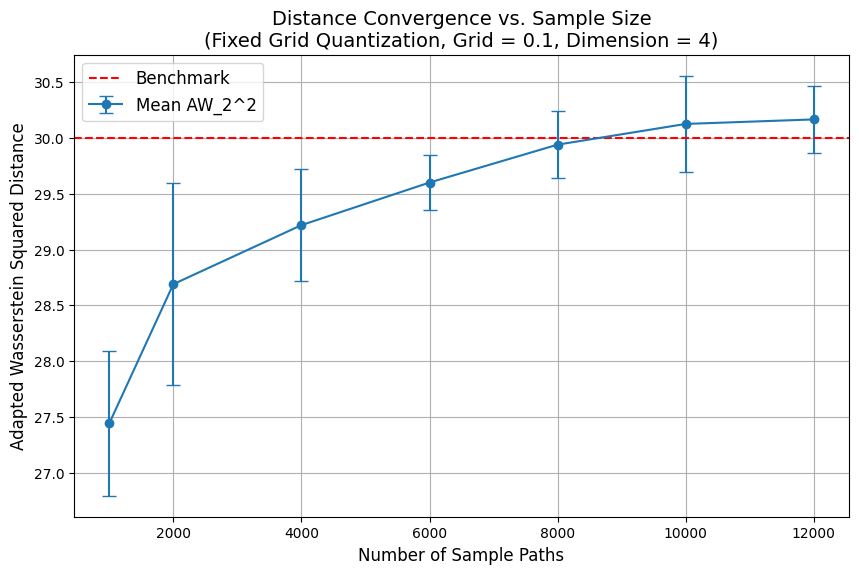

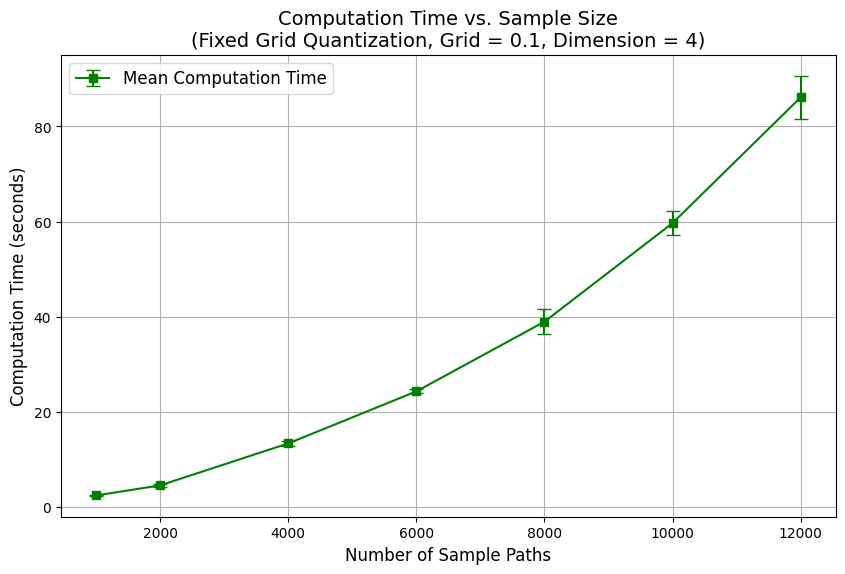

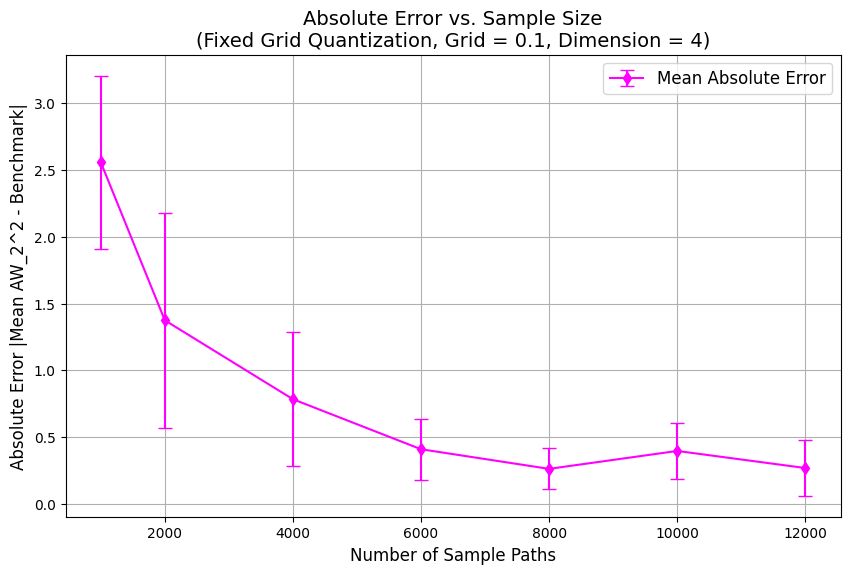

In [6]:
sample_list = sorted(aggregated.keys())
mean_distances = [aggregated[n]["mean_distance"] for n in sample_list]
std_distances = [aggregated[n]["std_distance"] for n in sample_list]
mean_times = [aggregated[n]["mean_time"] for n in sample_list]
std_times = [aggregated[n]["std_time"] for n in sample_list]
mean_abs_errors = [aggregated[n]["mean_abs_error"] for n in sample_list]
std_abs_errors = [aggregated[n]["std_abs_error"] for n in sample_list]
benchmark = aggregated[sample_list[0]]["benchmark"]  # assuming benchmark is the same across sizes

# Plot 1: Distance Convergence
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.axhline(y=benchmark, color="red", linestyle="--", label="Benchmark")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(Fixed Grid Quantization, Grid = 0.1, Dimension = 4)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(Fixed Grid Quantization, Grid = 0.1, Dimension = 4)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 3: Absolute Error
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_abs_errors, yerr=std_abs_errors, fmt="d-", capsize=5, color="magenta", label="Mean Absolute Error")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Absolute Error |Mean AW_2^2 - Benchmark|", fontsize=12)
plt.title("Absolute Error vs. Sample Size\n(Fixed Grid Quantization, Grid = 0.1, Dimension = 4)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [7]:
sample_sizes = [14000]
fixed_grid = 0.1

In [8]:
for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    
    for run in range(n_runs):
        # Generate two different random seeds (one for each matrix)
        seed1 = np.random.randint(10000)
        #seed2 = np.random.randint(10000)
        #while seed2 == seed1:  # Ensure they are different
            #seed2 = np.random.randint(10000)
        
        # Generate sample paths:
        # Process X (using matrix L) with seed1
        X, A = Lmatrix2paths(L, n_sample, seed=seed1, verbose=False)
        # Process Y (using matrix M) with seed2
        Y, B = Lmatrix2paths(M, n_sample, seed=seed1, verbose=False)
        
        # Compute the theoretical benchmark distance
        benchmark = adapted_wasserstein_squared(A, B)
        
        # Convert paths to adapted versions using the fixed grid
        adaptedX = path2adaptedpath(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath(Y, delta_n=fixed_grid)
        
        # Build quantization mapping
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}
        
        # Quantize paths using the mapping
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])
        
        # Sort the quantized paths (transposing to match the expected shape)
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)
        
        # Build conditional distributions
        mu_x = qpath2mu_x(qX)
        nu_y = qpath2mu_x(qY)
        mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn = list_repr_mu_x(mu_x, q2v)
        nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn = list_repr_mu_x(nu_y, q2v)
        
        # Compute the numerical adapted Wasserstein squared distance and record computation time
        t_start = time.perf_counter()
        AW_2square = nested2_parallel(mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn,
                                      nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn,
                                      n_processes=42)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Sample size {n_sample}, Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f} s")
    
    # Store the results for the current sample size
    results[n_sample] = {"distances": distances_runs,
                         "times": times_runs,
                         "benchmark": benchmark}


Running experiments for sample size: 14000


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 755.05it/s]


Sample size 14000, Run 1: AW_2^2 = 30.2015, Time = 143.9509 s


100%|█████████████████████████████████████████| 325/325 [00:11<00:00, 28.77it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 670.12it/s]


Sample size 14000, Run 2: AW_2^2 = 30.0963, Time = 108.4055 s


 77%|███████████████████████████████▋         | 251/325 [00:08<00:02, 30.37it/s]

100%|█████████████████████████████████████████| 325/325 [00:11<00:00, 29.14it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 709.10it/s]


Sample size 14000, Run 3: AW_2^2 = 30.1683, Time = 107.6093 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 729.70it/s]


Sample size 14000, Run 4: AW_2^2 = 30.4049, Time = 110.0610 s


100%|█████████████████████████████████████████| 325/325 [00:11<00:00, 28.52it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 698.82it/s]


Sample size 14000, Run 5: AW_2^2 = 29.9711, Time = 109.7624 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 706.23it/s]


Sample size 14000, Run 6: AW_2^2 = 29.6663, Time = 109.9759 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 722.28it/s]


Sample size 14000, Run 7: AW_2^2 = 30.5952, Time = 135.7210 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 699.63it/s]


Sample size 14000, Run 8: AW_2^2 = 30.6999, Time = 155.7673 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 707.18it/s]


Sample size 14000, Run 9: AW_2^2 = 30.2754, Time = 130.6192 s


100%|█████████████████████████████████████████| 324/324 [00:11<00:00, 28.53it/s]

100%|█████████████████████████████████████████| 324/324 [00:11<00:00, 27.68it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 712.47it/s]


Sample size 14000, Run 10: AW_2^2 = 30.2816, Time = 146.7586 s


In [9]:
print("\nAggregated Results:")
aggregated = {}
for n_sample in sorted(results.keys()):
    data = results[n_sample]
    dists = data["distances"]
    times = data["times"]
    bench = data["benchmark"]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    mean_time = np.mean(times)
    std_time = np.std(times)
    abs_errors = np.abs(dists - bench)
    mean_abs_err = np.mean(abs_errors)
    std_abs_err = np.std(abs_errors)
    aggregated[n_sample] = {
        "mean_distance": mean_dist,
        "std_distance": std_dist,
        "mean_time": mean_time,
        "std_time": std_time,
        "mean_abs_error": mean_abs_err,
        "std_abs_error": std_abs_err,
        "benchmark": bench
    }
    print(f"Sample Size: {n_sample}")
    print(f"  Mean AW_2^2: {mean_dist:.4f} ± {std_dist:.4f}")
    print(f"  Mean Time: {mean_time:.4f} s ± {std_time:.4f} s")
    print(f"  Mean Absolute Error: {mean_abs_err:.4f} ± {std_abs_err:.4f}")
    print(f"  Benchmark: {bench:.4f}\n")


Aggregated Results:
Sample Size: 1000
  Mean AW_2^2: 27.4429 ± 0.6474
  Mean Time: 2.4061 s ± 0.0523 s
  Mean Absolute Error: 2.5571 ± 0.6474
  Benchmark: 30.0000

Sample Size: 2000
  Mean AW_2^2: 28.6899 ± 0.9069
  Mean Time: 4.5265 s ± 0.3898 s
  Mean Absolute Error: 1.3744 ± 0.8062
  Benchmark: 30.0000

Sample Size: 4000
  Mean AW_2^2: 29.2184 ± 0.5033
  Mean Time: 13.3574 s ± 0.5137 s
  Mean Absolute Error: 0.7839 ± 0.4997
  Benchmark: 30.0000

Sample Size: 6000
  Mean AW_2^2: 29.6001 ± 0.2435
  Mean Time: 24.2961 s ± 0.4150 s
  Mean Absolute Error: 0.4095 ± 0.2268
  Benchmark: 30.0000

Sample Size: 8000
  Mean AW_2^2: 29.9394 ± 0.2981
  Mean Time: 38.9547 s ± 2.5643 s
  Mean Absolute Error: 0.2626 ± 0.1535
  Benchmark: 30.0000

Sample Size: 10000
  Mean AW_2^2: 30.1248 ± 0.4317
  Mean Time: 59.6869 s ± 2.6080 s
  Mean Absolute Error: 0.3967 ± 0.2112
  Benchmark: 30.0000

Sample Size: 12000
  Mean AW_2^2: 30.1653 ± 0.2965
  Mean Time: 86.1223 s ± 4.5516 s
  Mean Absolute Error: 0.

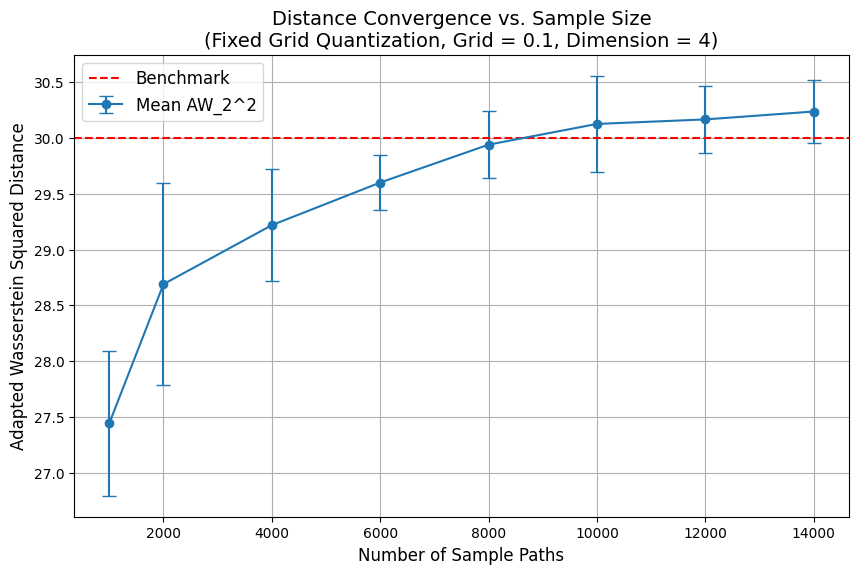

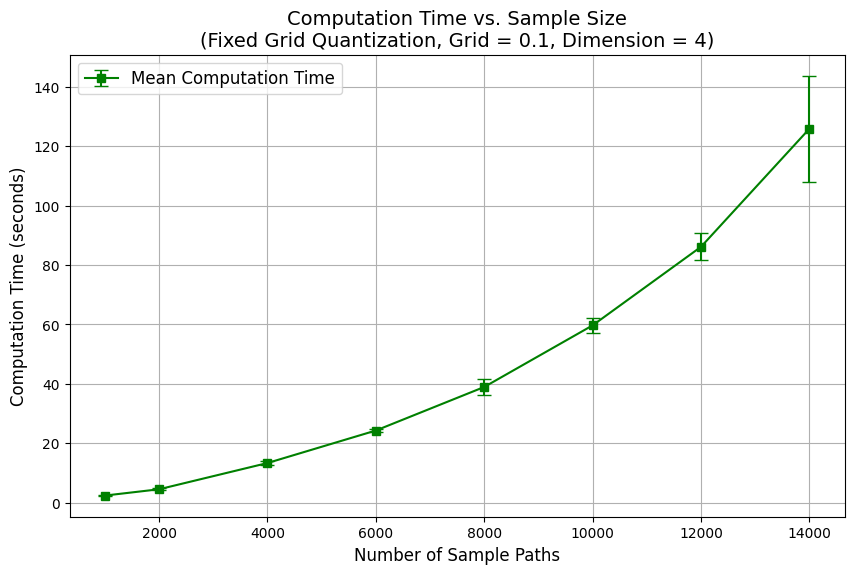

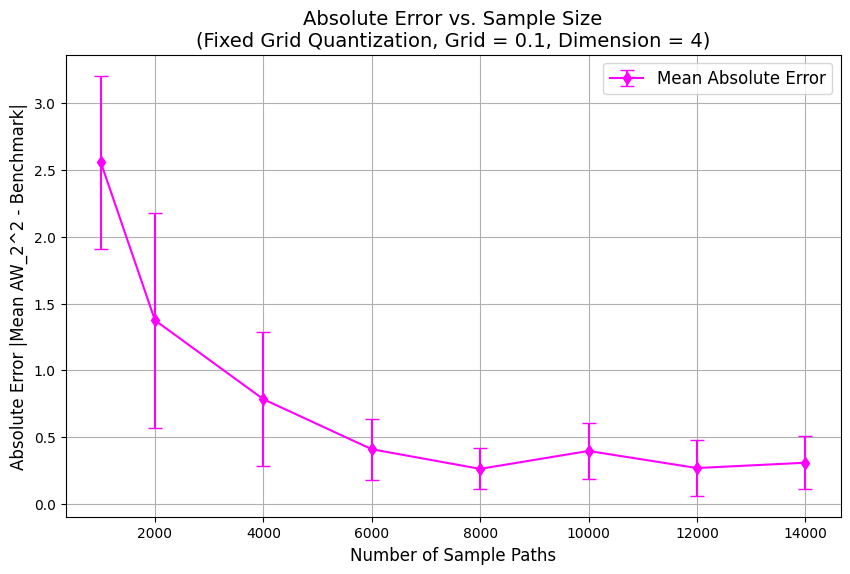

In [10]:
sample_list = sorted(aggregated.keys())
mean_distances = [aggregated[n]["mean_distance"] for n in sample_list]
std_distances = [aggregated[n]["std_distance"] for n in sample_list]
mean_times = [aggregated[n]["mean_time"] for n in sample_list]
std_times = [aggregated[n]["std_time"] for n in sample_list]
mean_abs_errors = [aggregated[n]["mean_abs_error"] for n in sample_list]
std_abs_errors = [aggregated[n]["std_abs_error"] for n in sample_list]
benchmark = aggregated[sample_list[0]]["benchmark"]  # assuming benchmark is the same across sizes

# Plot 1: Distance Convergence
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.axhline(y=benchmark, color="red", linestyle="--", label="Benchmark")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(Fixed Grid Quantization, Grid = 0.1, Dimension = 4)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(Fixed Grid Quantization, Grid = 0.1, Dimension = 4)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 3: Absolute Error
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_abs_errors, yerr=std_abs_errors, fmt="d-", capsize=5, color="magenta", label="Mean Absolute Error")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Absolute Error |Mean AW_2^2 - Benchmark|", fontsize=12)
plt.title("Absolute Error vs. Sample Size\n(Fixed Grid Quantization, Grid = 0.1, Dimension = 4)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()